# The Battle of Neighborhoods: Indian Restaurants in NYC

In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import requests
from bs4 import BeautifulSoup
import geocoder
import os
import folium # map rendering library
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline


print('Libraries imported.')

Libraries imported.


In [2]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

In [20]:
def get_venues(lat,lng):
    
    #set variables
    radius=1000
    LIMIT=100
    CLIENT_ID = '1GV2AVB3ZXMPSS1PHC00BZUPRQGJ3GSDZ0AWTEBTD3FOFAYH'
    CLIENT_SECRET = 'PB5M24H1TNWCXZCJMAOA2FB3VHOWQIRRLWUCQJWSFSBW3GJR'
    VERSION = '20191010'
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df
    

In [21]:
def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
    
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
    return new_york_data

In [22]:
new_york_data=get_new_york_data()

In [23]:
new_york_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [24]:
new_york_data.shape

(306, 4)

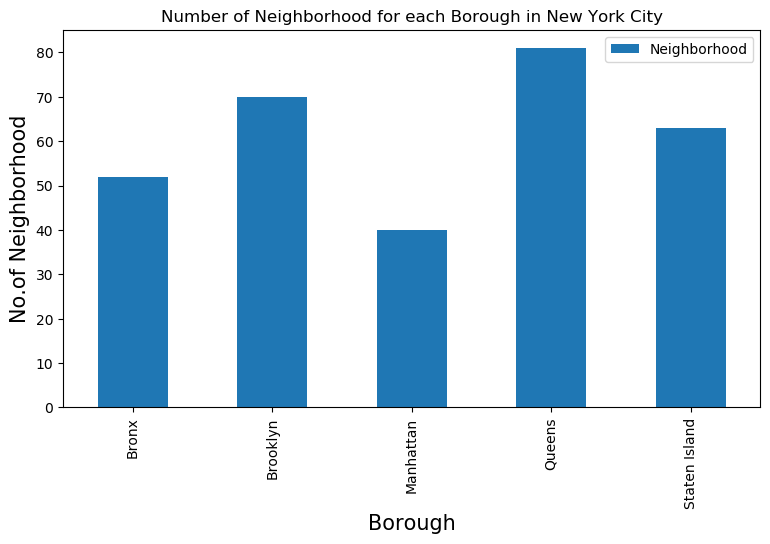

In [25]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Neighborhood for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Neighborhood', fontsize=15)
#giving a bar plot
new_york_data.groupby('Borough')['Neighborhood'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

In [27]:
from tqdm import tqdm_notebook
column_names=['Borough', 'Neighborhood', 'ID','Name']
indian_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in tqdm_notebook(new_york_data.values.tolist()):
    Borough, Neighborhood, Latitude, Longitude=row
    try:
        venues = get_venues(Latitude,Longitude)
    except:
        continue
    indian_restaurants=venues[venues['Category']=='Indian Restaurant']   
    for restaurant_detail in indian_restaurants.values.tolist():
        id, name, category = restaurant_detail
        indian_rest_ny = indian_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name': name
                                               }, ignore_index=True)

In [28]:
indian_rest_ny.head()

,Borough,Neighborhood,ID,Name
0,Bronx,Woodlawn,4c0448d9310fc9b6bf1dc761,Curry Spot
1,Bronx,Parkchester,4c194631838020a13e78e561,Melanies Roti Bar And Grill
2,Bronx,Spuyten Duyvil,4c04544df423a593ac83d116,Cumin Indian Cuisine
3,Bronx,Concourse,551b7f75498e86c00a0ed2e1,Hungry Bird
4,Bronx,Unionport,4c194631838020a13e78e561,Melanies Roti Bar And Grill


In [29]:
indian_rest_ny.shape

(154, 4)

Thus, we can see that we have got 154 Indian Restaurants across New York City!

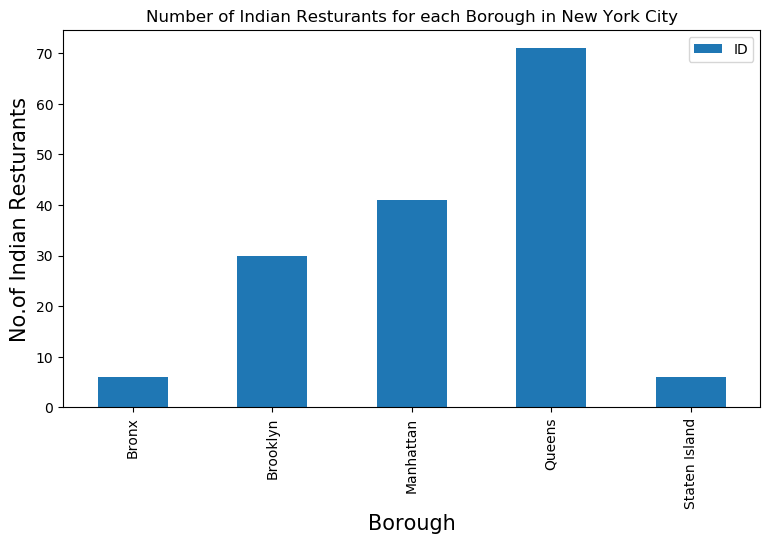

In [30]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Indian Resturants for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Indian Resturants', fontsize=15)
#giving a bar plot
indian_rest_ny.groupby('Borough')['ID'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

We see that Queens has the largest number of Indian Restaurants

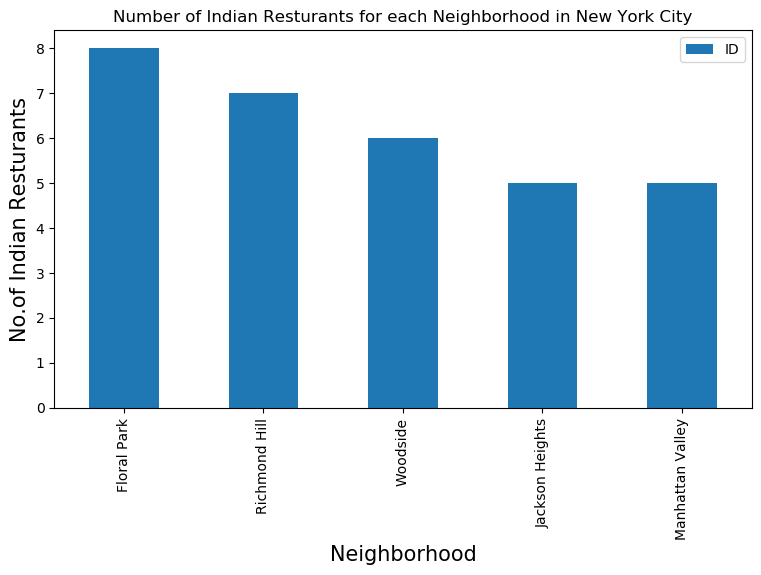

In [31]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Indian Resturants for each Neighborhood in New York City')
#On x-axis
plt.xlabel('Neighborhood', fontsize = 15)
#On y-axis
plt.ylabel('No.of Indian Resturants', fontsize=15)
#giving a bar plot
indian_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(5).plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

In [32]:
indian_rest_ny[indian_rest_ny['Neighborhood']=='Floral Park']

,Borough,Neighborhood,ID,Name
106,Queens,Floral Park,527ffc0811d2d329d5e49abd,Jackson Diner
107,Queens,Floral Park,4e4e3e22bd4101d0d7a5c2d1,Kerala Kitchen
108,Queens,Floral Park,4b647b56f964a520c4b62ae3,Usha Foods & Usha Sweets
109,Queens,Floral Park,4b787c49f964a5209cd12ee3,Santoor Indian Restaurant
110,Queens,Floral Park,4c0c01e0bbc676b00d6b4cd5,Mumbai Xpress
111,Queens,Floral Park,4c76ff35a5676dcb72671721,Flavor Of India
112,Queens,Floral Park,4df0f39dd4c04d0392c853ea,Sagar Chinese
113,Queens,Floral Park,4e6bfe1c7d8b2c711b17bbe5,Surya sweets and snacks


So Floral Park in Queens has the highest number of Indian Resturants with a total count of 8.

### Conclusion 
- Queens and Manhattan are the best Borough with the highest number of Indian Restaurants!
- Floral Park, Richmond Hill, Woodside, Jackson Heights, Manhattan Valley are the best neighbourhoods to live in if you fancy Indian Cuisine.
- Brooklyn seems to have market potential that can be harnessed by setting up an Indian Restaurant in the Borough.